# Fig 4a

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import os
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

In [6]:
mutation_info_df = pd.read_csv('Vitality_infant_FLG_mutation_derivedFrom_metagenomes.txt', sep='\t')
mutation_info_df.head()

,Infant ID,Position,Reference allele,Alternative allele,Impact,Genotype,Reference allele read count,Alternative allele read count
0,865,chr1:152303407,CT,C,p.Ser3828fs,0/1,9,4
1,891,chr1:152313385,G,A,p.Arg501*,0/1,13,4
2,911,chr1:152312255,CT,C,p.Gln877fs,0/1,5,3
3,986,chr1:152312600,CACTGACTG,CACTG,p.Ser761fs,0/1,10,3
4,989,chr1:152312391,G,C,p.Ser832*,0/1,6,3


/tmp/ipykernel_4111994/1475609582.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


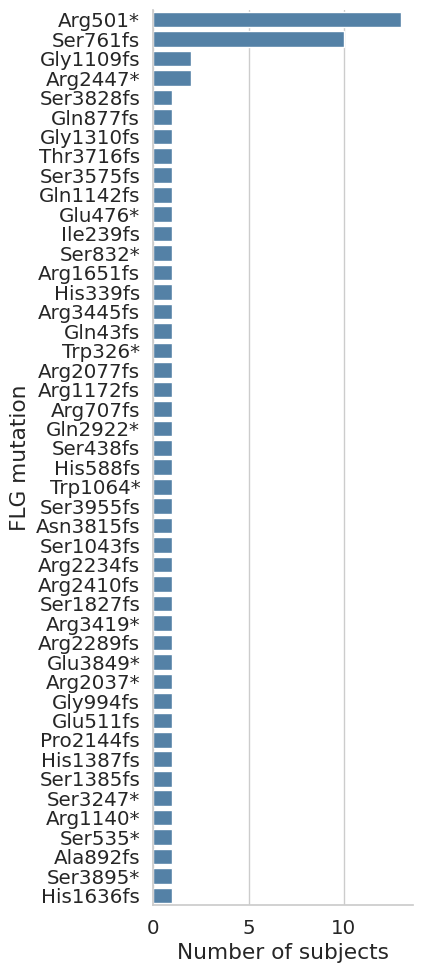

In [7]:
mutation_info_df['count'] = 1
sns.set(style='whitegrid', font_scale=1.3)
plt.figure(figsize=(4.5,10))
ax = sns.countplot(data=mutation_info_df, y='Impact', color='steelblue', order=mutation_info_df['Impact'].value_counts().index)
labels = [tick.get_text() for tick in ax.get_yticklabels()]
new_labels = [label.replace("p.", "") for label in labels]
ax.set_yticklabels(new_labels)
plt.ylabel('FLG mutation')
plt.xlabel('Number of subjects')
sns.despine(top=True)
plt.tight_layout()

# Fig 4b

In [1]:
library(ggplot2)
library(ggpubr)
library(readxl)
library(dplyr)
library(RColorBrewer)
library(reshape2)
library(phyloseq)
library(caret)
library("vsn")
library(vegan)
library(stringr)
library(UpSetR)
library(rjson)
library(MicrobiomeStat)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to B

In [4]:
ps <- readRDS(file="/home/zeyang.shen/lab_data/PI/Vitality/RDS/bracken_results_ns38-46+56-57+62+66+94+96_Species_BasedOn_20220511_standard+SMGC+ELSGv2+ns66+T2T.Aug2025.t10.ps.rds")
ps <- subset_taxa(ps, Genus!="Homo")
sample_data.df <- sample_data(ps)
sample_data.df$total_abundance <- rowSums(otu_table(ps))
sample_data(ps) <- sample_data.df
ps <- subset_samples(ps, location!="novaseq6000")
ps <- subset_samples(ps, group!=".")
ps <- subset_samples(ps, !(site_specific %in% c("Ctrl", "PrepCtrl", "(empty)", "N", "ZymoD6306")))
ps <- tax_glom(ps, taxrank="Species", NArm=FALSE)
table(sample_data(ps)$babymom_site_visit, sample_data(ps)$group2)

         
          1_no 1_yes 2_no 2_yes 3_yes 4_no
  B:Ac:T1    5    11    2     5    29   28
  B:Ac:T3   22    71   24    30   169  108
  B:Ch:T1    5    11    2     5    28   28
  B:Ch:T3   22    72   24    30   169  108
  F:Ac:T3    0     0    0     0     2    1
  M:Ac:T3    0    10    1     0    30   26

[1] "Total samples: 1078"
[1] "Samples selected: 1072"
[1] "After filter on reads: 1068"
[1] "Subsampling to reads: 119027"


`set.seed(10)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(10); .Random.seed` for the full vector

...

1246OTUs were removed because they are no longer 
present in any sample after random subsampling


...



         
          1_no 1_yes 2_no 2_yes 3_yes 4_no
  B:Ac:T1    5    10    2     5    29   28
  B:Ac:T3   21    71   24    30   168  106
  B:Ch:T1    5    11    2     5    28   28
  B:Ch:T3   22    71   24    30   168  105
  F:Ac:T3    0     0    0     0     2    1
  M:Ac:T3    0    10    1     0    30   26

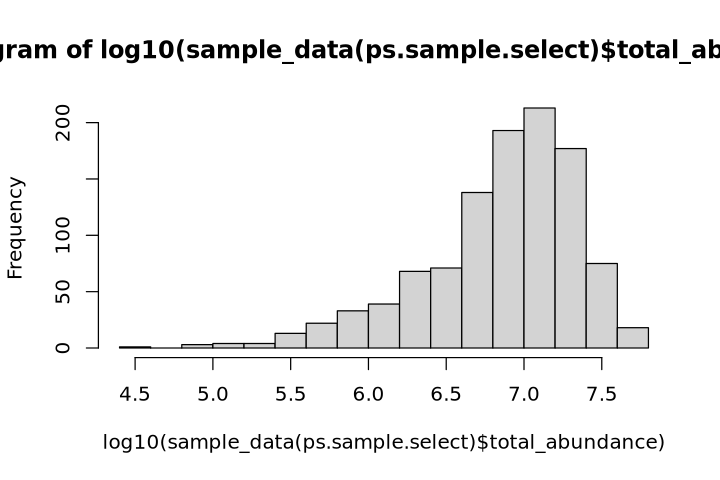

In [5]:
exclude_samples <- c("Met4959", "Met4960", #air control and Ac:T3 likely swapped
                     "Met5191", "Met5192", #control has more reads than samples
                     "Met4929", #similar number of reads as air control
                     "Met5528" #only 8700 total reads
                    )

#1.Select samples
print(paste("Total samples:", nsamples(ps)))
ps.sample.select <- subset_samples(ps, !(Sample %in% exclude_samples))
print(paste("Samples selected:", nsamples(ps.sample.select)))
options(repr.plot.width = 6, repr.plot.height = 4)
hist(log10(sample_data(ps.sample.select)$total_abundance))

##filter sample by total reads
ps.sample.select2 <- subset_samples(ps.sample.select, total_abundance > 100000)
print(paste("After filter on reads:", nsamples(ps.sample.select2)))

##rarefication
print(paste("Subsampling to reads:", min(rowSums(otu_table(ps.sample.select2)))))
ps.rarefy <- rarefy_even_depth(ps.sample.select2, rngseed=10)

table(sample_data(ps.sample.select2)$babymom_site_visit, sample_data(ps.sample.select2)$group2)

In [6]:
noFLG_mut_subjs <- readLines("../putative_infants_with_no_FLG_mutation_from_metagenomes.txt")
noFLG_mut_subjs <- paste0("V",noFLG_mut_subjs,"B")
noFLG_mut_subjs

[1] "V1030B" "V1041B" "V1062B" "V1097B" "V1104B" "V1105B" "V1162B" "V1175B"
 [9] "V1178B" "V1205B" "V1225B" "V1241B" "V1247B" "V1273B" "V1280B" "V1301B"
[17] "V1333B" "V1469B" "V1728B" "V1850B" "V1876B" "V1957B" "V1982B" "V2049B"
[25] "V2063B" "V916B"  "V940B"  "V956B"  "V961B"  "V970B"  "V981B"  "V987B"

In [7]:
data <- read.table("../Vitality_infant_FLG_mutation_derivedFrom_metagenomes.txt", sep = "\t", header = TRUE)
FLG_mut_subjs <- data[[1]]
FLG_mut_subjs <- paste0("V",as.character(FLG_mut_subjs),"B")
FLG_mut_subjs

[1] "V865B"  "V891B"  "V911B"  "V986B"  "V989B"  "V1015B" "V1015B" "V1033B"
 [9] "V1060B" "V1096B" "V1126B" "V1131B" "V1131B" "V1159B" "V1230B" "V1248B"
[17] "V1259B" "V1260B" "V1262B" "V1295B" "V1295B" "V1303B" "V1307B" "V1315B"
[25] "V1319B" "V1337B" "V1341B" "V1341B" "V1347B" "V1359B" "V1372B" "V1372B"
[33] "V1374B" "V1376B" "V1414B" "V1438B" "V1464B" "V1479B" "V1528B" "V1533B"
[41] "V1533B" "V1544B" "V1554B" "V1568B" "V1619B" "V1622B" "V1654B" "V1671B"
[49] "V1683B" "V1683B" "V1689B" "V1700B" "V1700B" "V1704B" "V1705B" "V1731B"
[57] "V1787B" "V1818B" "V1835B" "V1848B" "V1860B" "V1866B" "V1898B" "V1930B"
[65] "V1933B" "V2001B" "V2001B" "V2006B" "V2035B"

In [8]:
sample_data.df <- sample_data(ps.sample.select2)
sample_data.df$FLG <- NaN
sample_data.df$FLG[sample_data.df$subject_id %in% FLG_mut_subjs] <- TRUE
sample_data.df$FLG[sample_data.df$subject_id %in% noFLG_mut_subjs] <- FALSE
sample_data(ps.sample.select2) <- sample_data.df
ps.subset <- subset_samples(ps.sample.select2, !is.na(FLG))
table(sample_data(ps.subset)$any_eczema_ever_d, sample_data(ps.subset)$FLG, sample_data(ps.subset)$babymom_site_visit)

, ,  = B:Ac:T1

     
       0  1
  no   3  6
  yes  8 15

, ,  = B:Ac:T3

     
       0  1
  no   9 13
  yes 22 44

, ,  = B:Ch:T1

     
       0  1
  no   3  6
  yes  8 15

, ,  = B:Ch:T3

     
       0  1
  no  10 12
  yes 22 43


In [7]:
tax.tb <- as.data.frame(tax_table(ps.sample.select2))
cov.file <- "/home/zeyang.shen/lab_data/PI/Vitality/RefSeq+ELSG+SMGC.default.coverm.tsv"
cov.df <- read.csv(cov.file, sep="\t")
cov.df$Species <- unlist(lapply(cov.df[,1], function(x) {paste(unlist(str_split(x, " "))[1:2], collapse=" ")}))
cov.lst <- c()
for (s in tax.tb$Species){
    if (s %in% cov.df$Species){
        cov.lst <- c(cov.lst, max(cov.df[cov.df$Species==s,"X0.99"]))
    } else {
        cov.lst <- c(cov.lst, NaN)
    }
}
tax.tb$Coverage <- cov.lst

In [8]:
run_linda_on_phyloseq <- function(ps.deseq, 
                                  comparison_label = NULL, 
                                  n.cores = 8) {
  # Build feature table (relative abundance)
  feature.table <- data.frame(t(otu_table(ps.deseq)))
  rel_abund <- sweep(feature.table, 2, colSums(feature.table), FUN = "/")
  
  # Metadata
  meta.table <- data.frame(sample_data(ps.deseq))
  
  # Try LinDA
  tryCatch({
    linda.obj <- linda(
      rel_abund,
      meta.table,
      formula = "~FLG",
      feature.dat.type = "proportion",
      is.winsor = TRUE,
      prev.filter = 0.3,
      mean.abund.filter = 1e-5,
      p.adj.method = "BH",
      n.cores = n.cores
    )
    
    linda_output <- linda.obj$output[[1]]
    linda.res <- linda_output[, c("log2FoldChange", "padj")]
    colnames(linda.res) <- c("log2FC", "qval")
    linda.res$taxID <- rownames(linda.res)
    linda.res$method <- "LinDA"
    
    # Add taxonomic annotations if available
    display.df <- data.frame(linda.res, tax_table(ps.deseq)[linda.res$taxID,])
    if (!is.null(comparison_label)) {
      display.df$comparison <- comparison_label
    }
    
    # Add abundance and prevalence metrics
    display.df$abundance.median <- apply(otu_table(ps.deseq) / rowSums(otu_table(ps.deseq)), 2, median)[display.df$taxID]
    display.df$abundance.max <- apply(otu_table(ps.deseq) / rowSums(otu_table(ps.deseq)), 2, max)[display.df$taxID]
    display.df$prevalence <- apply(otu_table(ps.deseq), 2, function(x) sum(x > 0) / length(x))[display.df$taxID]
    display.df$coverage <- tax.tb[display.df$taxID, "Coverage"]    
    return(display.df)
    
  }, error = function(e) {
    message("LinDA failed: ", e$message)
    return(NULL)
  })
}

In [9]:
DA.res <- c()

ps.subset <- subset_samples(ps.sample.select2, babymom_site_visit=="B:Ac:T3" & !is.na(FLG))
for (affect in c("yes","no")){
    ps.deseq <- subset_samples(ps.subset, (any_eczema_ever_d=="yes"&skin_swab_taken_at_eczema_T3==affect))
    print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$FLG))
    cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("ADflare", affect, "_AcT3"))
    DA.res <- rbind(DA.res, cur.res)
    flush.console()
}

for (site in c("B:Ac:T3", "B:Ch:T3", "B:Ch:T1", "B:Ac:T1")){
    for (ecz in c("yes", "no")){
        ps.subset <- subset_samples(ps.sample.select2, babymom_site_visit==site & !is.na(FLG))
        ps.deseq <- subset_samples(ps.subset, (any_eczema_ever_d==ecz))
        print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$FLG))
        cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("AD",ecz,"_",str_replace_all(str_replace_all(site,"B:",""),":","")))
        DA.res <- rbind(DA.res, cur.res)
        flush.console()
    }
}

           
             0  1
  1_yes_yes  3  6
  2_yes_yes  0  2
  3_yes_yes  2 10
7815  features are filtered!
The filtered data has  23  samples and  1697  features will be tested!
Fit linear models ...
Completed.
          
            0  1
  1_yes_no  4  8
  2_yes_no  2  2
  3_yes_no 11 16
7799  features are filtered!
The filtered data has  43  samples and  1713  features will be tested!
Fit linear models ...
Completed.
           
             0  1
  1_yes_no   4  8
  1_yes_yes  3  6
  2_yes_no   2  2
  2_yes_yes  0  2
  3_yes_no  11 16
  3_yes_yes  2 10
7776  features are filtered!
The filtered data has  66  samples and  1736  features will be tested!
Fit linear models ...
Completed.
         
          0 1
  1_no_no 2 2
  2_no_no 0 3
  4_no_no 7 8
7716  features are filtered!
The filtered data has  22  samples and  1796  features will be tested!
Fit linear models ...
Completed.
           
             0  1
  1_yes_no   4  7
  1_yes_yes  3  6
  2_yes_no   2  2
  2_yes_yes  0  2

In [10]:
abund.cutoff <- 0
fc.cutoff <- 0
q.cutoff <- 0.1
cov.cutoff <- 0.6
# DA.res$qval <- p.adjust(DA.res$pval, method = "BH")
DA.res$log10q <- -log10(DA.res$qval)
DA.res$method_comparison <- paste0(DA.res$comparison, "_", DA.res$method)
DA.res <- DA.res[order(DA.res$qval),]

all.sig.taxa <- c()
for (comp in unique(DA.res$comparison)){
    print(comp)
    pos.sig.taxa1 <- subset(DA.res, comparison==comp & log2FC > fc.cutoff & abundance.median > abund.cutoff & (coverage > cov.cutoff | Domain!='Bacteria'))$taxID
    if (length(pos.sig.taxa1)>0){
        pos.mtx <- dcast(subset(DA.res, comparison==comp & taxID %in% pos.sig.taxa1), taxID+comparison~method, value.var = "qval", fill = 1)
        pos.sig.taxa2 <- subset(pos.mtx, (LinDA < q.cutoff))$taxID
        print(paste("Increased:", length(pos.sig.taxa2)))
        if (length(pos.sig.taxa2) > 0){print(tax.tb[pos.sig.taxa2,c("Species", "Coverage")])}
        all.sig.taxa <- c(all.sig.taxa, pos.sig.taxa2)
    }
    
    neg.sig.taxa1 <- subset(DA.res, comparison==comp & log2FC < -fc.cutoff & abundance.median > abund.cutoff & (coverage > cov.cutoff | Domain!='Bacteria'))$taxID
    if (length(neg.sig.taxa1)>0){
        neg.mtx <- dcast(subset(DA.res, comparison==comp & taxID %in% neg.sig.taxa1), taxID+comparison~method, value.var = "qval", fill = 1)
        neg.sig.taxa2 <- subset(neg.mtx, (LinDA < q.cutoff))$taxID
        print(paste("Decreased:", length(neg.sig.taxa2)))
        if (length(neg.sig.taxa2) > 0){print(tax.tb[neg.sig.taxa2,c("Species", "Coverage")])}
        all.sig.taxa <- c(all.sig.taxa, neg.sig.taxa2)
    }
}
DA.sig.res <- subset(DA.res, taxID %in% all.sig.taxa)
length(all.sig.taxa)

[1] "ADyes_AcT3"
[1] "Increased: 0"
[1] "Decreased: 1"
                     Species  Coverage
197575 Haemophilus aegyptius 0.7276019
[1] "ADyes_ChT3"
[1] "Increased: 1"
                   Species Coverage
76776 Malassezia slooffiae      NaN
[1] "Decreased: 8"
                           Species  Coverage
197575       Haemophilus aegyptius 0.7276019
28449           Neisseria subflava 0.7523096
5000089  Streptococcus sp001813295 0.7279240
5000092 Granulicatella sp001071995 0.8867609
5000363  Streptococcus sp900766505 0.7676810
589437           Prevotella scopos 0.6182714
68891        Streptococcus peroris 0.9346669
68892       Streptococcus infantis 0.9019728
[1] "ADflareyes_AcT3"
[1] "Increased: 0"
[1] "Decreased: 17"
                               Species  Coverage
1234680          Streptococcus rubneri 0.7137052
1313          Streptococcus pneumoniae 0.9174693
1318       Streptococcus parasanguinis 0.7038247
1379               Gemella haemolysans 0.9447026
1583331          Porphyromona

[1] 27

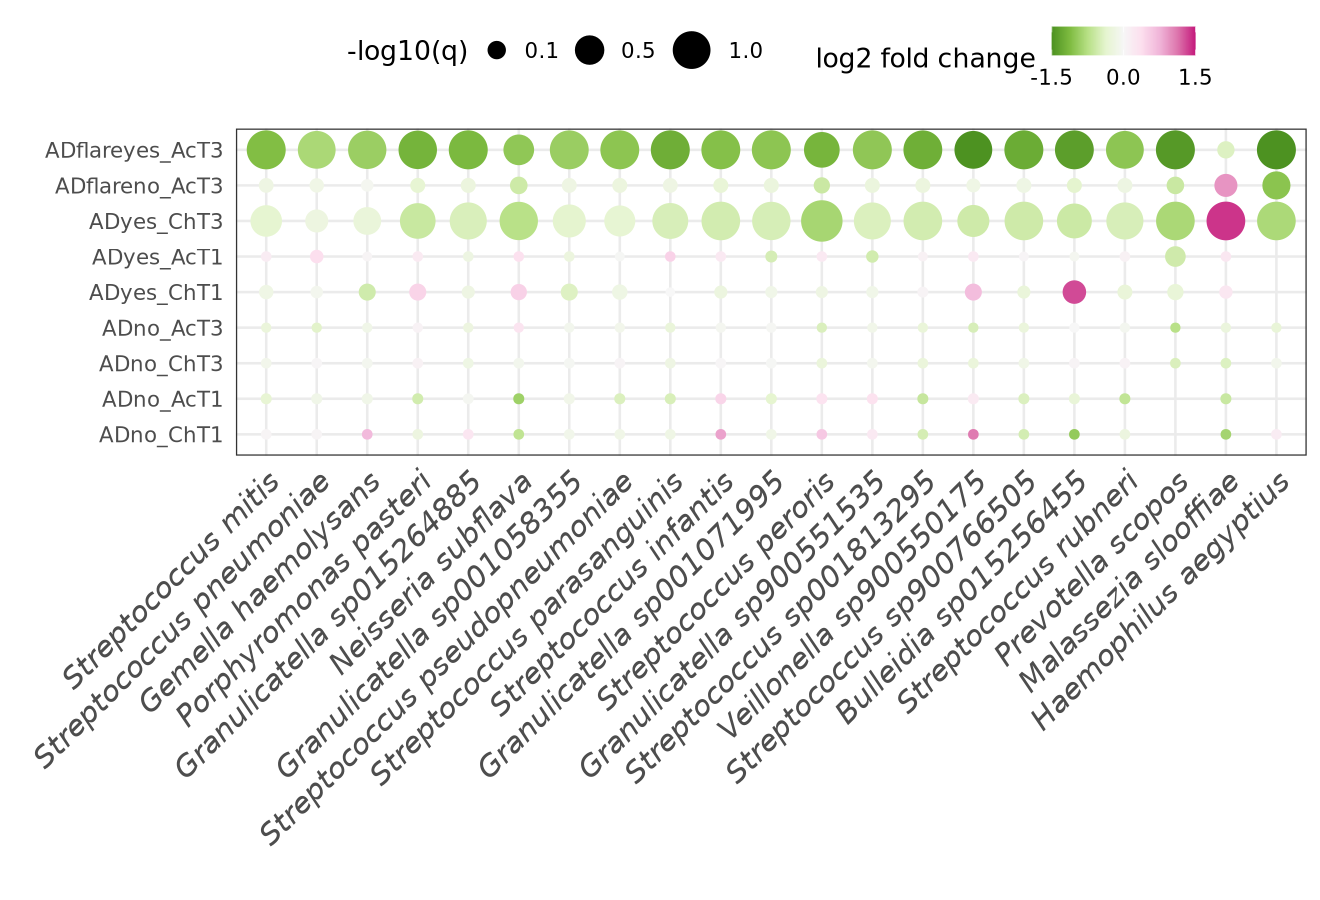

In [11]:
select.groups <- c("ADno_ChT1","ADno_AcT1","ADno_ChT3","ADno_AcT3",
                   "ADyes_ChT1","ADyes_AcT1","ADyes_ChT3","ADflareno_AcT3","ADflareyes_AcT3")
DA.sig.res <- subset(DA.sig.res, comparison %in% select.groups)
DA.sig.res$comparison <- factor(DA.sig.res$comparison, level=select.groups)

colors <- colorRampPalette(rev(brewer.pal(9, "PiYG")))(255)
options(repr.plot.width = 11, repr.plot.height = 7.5)
dp1 <- ggplot(DA.sig.res, aes(x=reorder(Species, -abundance.median), y=comparison, color = log2FC, size = log10q)) + 
    geom_point()+
    scale_color_gradientn(colours = colors, limits = c(-1.5,1.5), breaks = c(-1.5, 0, 1.5), oob = scales::squish, name = 'log2 fold change')+
    scale_size_continuous(range=c(2,11), breaks=c(0.1,0.5,1,1.5), name='-log10(q)')+
    labs(x="", y="")+
    theme_bw(base_size=16)+
    theme(axis.text.x = element_text(size=18, angle = 45, vjust = 1, hjust=1, face="italic"), 
          legend.position='top')+
    theme(axis.ticks = element_blank())
dp1
ggsave(dp1, width=11, height=7.5, file="../figs/AD_DA_FLG.eps", device="eps")

# Fig 4c, S4

In [30]:
vst <- "T1"
ps.subset2 <- subset_samples(ps.sample.select2, visit==vst & babymom=="B" & !is.na(FLG))
select_melt <- psmelt(ps.subset2)

Warning message in psmelt(ps.subset2):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”


In [37]:
substr <- "Streptococcus mitis" #Malassezia slooffiae, Streptococcus mitis/peroris, Porphyromonas pasteri
display_set <- subset(select_melt, grepl(substr, Species))
unique(display_set$OTU)
# display_set <- subset(select_melt, OTU=="5000186")
# select.group2 <- c("3_yes", "1_yes", "2_yes", "1_no", "2_no", "4_no")
# display_set <- subset(display_set, group2 %in% select.group2)
# display_set$group2 <- factor(display_set$group2, level=select.group2)
display_set$FLG <- factor(display_set$FLG, level=c(0,1))
display_set$new.group <- ifelse(
  display_set$babymom_site_visit == "B:Ac:T3",
  paste(display_set$any_eczema_ever_d, display_set$skin_swab_taken_at_eczema_T3, sep = "_"),
  display_set$any_eczema_ever_d
)
display_set$group_FLG <- paste0(display_set$new.group,"_",display_set$FLG)
display_set$group_FLG <- factor(display_set$group_FLG, level=c("yes_yes_0","yes_yes_1","yes_no_0","yes_no_1","no_no_0","no_no_1",
                                                               "yes_0","yes_1","no_0","no_1"))
if (vst == "T1"){
    display_set$new.group <- factor(display_set$new.group, level=c("yes","no"))
} else{
    display_set$new.group <- factor(display_set$new.group, level=c("yes_yes","yes_no","no_no","yes","no"))
}
display_set$Relative.Abundance <- (display_set$Abundance/display_set$total_abundance)*100
table(display_set$new.group)

[1] "28037"


yes  no 
 46  18 

babymom_site_visit,new.group,.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
B:Ac:T1,no,Relative.Abundance,0,1,0.9047619,0.9,0.90,ns,Wilcoxon,1.83422
B:Ch:T1,no,Relative.Abundance,0,1,0.7142857,0.9,0.71,ns,Wilcoxon,1.83422
B:Ac:T1,yes,Relative.Abundance,0,1,0.3572241,0.9,0.36,ns,Wilcoxon,1.83422
B:Ch:T1,yes,Relative.Abundance,0,1,0.8251773,0.9,0.83,ns,Wilcoxon,1.83422


Warning message in scale_y_log10(expand = expansion(mult = c(0.05, 0.1))):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(expand = expansion(mult = c(0.05, 0.1))):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message in scale_y_log10(expand = expansion(mult = c(0.05, 0.1))):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(expand = expansion(mult = c(0.05, 0.1))):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”


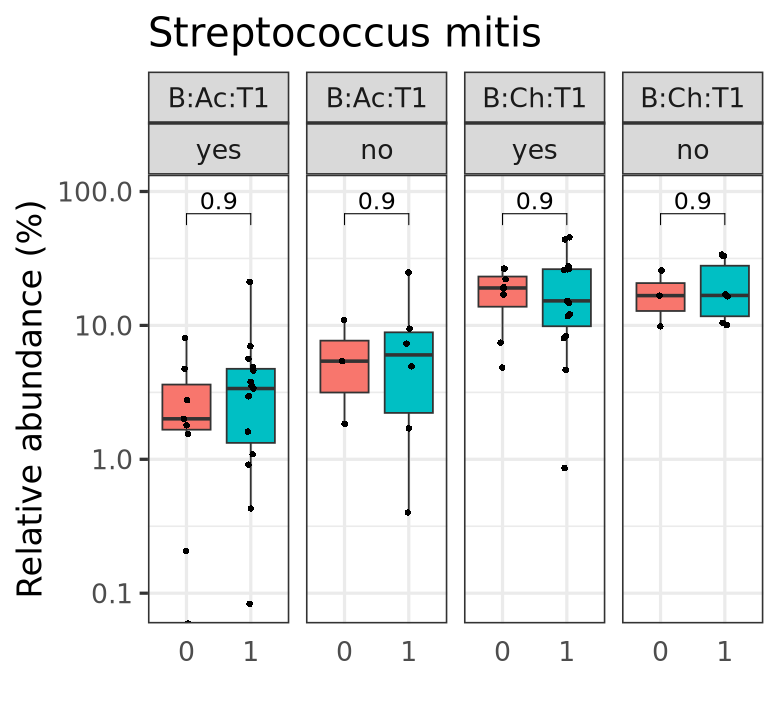

In [42]:
width.dct <- list("T1"=6.5, "T3"=9)
options(repr.plot.width = width.dct[[vst]], repr.plot.height = 6)
my_comparisons <- list(c("0", "1"))
# my_cols <- brewer.pal(2, "Set2")[1:6]
pvals <- compare_means(
  Relative.Abundance ~ FLG,
  data = display_set,
  method = "wilcox.test",
  p.adjust.method = "BH",
    group.by = c("babymom_site_visit","new.group")
)
pvals$y.position <- abs(log10(max(display_set$Relative.Abundance)*1.2))
pvals
p1 <- ggplot(display_set, aes(
    x=FLG, y=Relative.Abundance, fill=FLG)) + 
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(shape=16, position=position_jitter(0.05)) +
    stat_pvalue_manual(pvals, label="p.adj", size=5) +
    labs(y="Relative abundance (%)", x="", title=substr) +
    scale_y_log10(expand = expansion(mult = c(0.05, 0.1))) +
    facet_grid(~babymom_site_visit+new.group, scales="free", space="free") +
    theme_bw(base_size=20) +
    # scale_fill_manual(values = my_cols) +
    theme(axis.text.x = element_text(angle=0, vjust=0.5), axis.ticks.x=element_blank(), legend.position = "none")
p1
ggsave(p1, width=width.dct[[vst]], height=6, file=paste0("~/figs/AD_abundance_FLG_",vst,"_", str_replace(substr, " ", "_"), ".eps"), device="eps")